In [214]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import math

plt.style.use('ggplot')

### Белый шум

Возьмем в качестве белого шума равномерно распределенную на интервале (-1, 1) случайную величину

Характеристики: 
$$R(\tau)=\sigma^2*\delta(\tau)$$
$$S(\omega)=\sigma_\omega^2$$

In [1608]:
n = 1000
t0 = 0
t1 = 10

t = np.linspace(t0, t1, n)

normal_noise = [np.random.normal() for _ in range(n)]
uniform_noise = [np.random.uniform(-1, 1) for _ in range(n)]

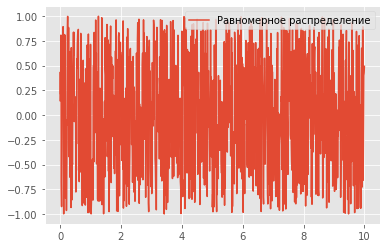

In [1609]:
plt.plot(t, uniform_noise, label='Равномерное распределение')
plt.legend();

### Параметры процесса

Задан процесс с автокорреляционной функцией вида
$$R_y(\tau)=e^{\alpha|\tau|}(1-\alpha|\tau|)$$

Спектральная плотность выражается в виде
$$S_y(\omega)=\frac{2D\alpha\omega^2}{\pi(\alpha^2+\omega^2)^2}$$

Частотная характеристика фильтра
$$W(s)=\sqrt{\frac{2D\alpha}{\pi\sigma^2}}\frac{s}{(\alpha + s)^2}$$

Импульсная харастеристика фильтра
$$h(\tau)=e^{\alpha\tau}(1-\alpha\tau) \sqrt{\frac{2D\alpha}{\pi\sigma^2}}$$

In [1570]:
σ = 1
α = 1
D = σ**2

m = 100
n = 200
t0 = 0
t1 = 10
dt = (t1 - t0) / n

#### Автокорреляционная функция

In [1571]:
def get_R(D, α):
    def R(τ):
        return D * np.exp(-α * abs(τ)) * (1 - α * abs(τ))
    
    return R

#### Импульсная харастеристика фильтра

In [1572]:
def get_h(D, α, σ):
    def h(τ):
        return np.exp(-α * τ) * (1 - α * τ) * np.sqrt((2 * D * α) / (math.pi * σ**2))
    
    return h

#### Спектральная плотность

In [1573]:
def get_S(D, α):
    def S(ω):
        return 2 * D * α * ω**2 / (math.pi * (α**2 + ω**2))**2
    
    return S

In [1574]:
h = get_h(D, α, σ)
R = get_R(D, α)
S = get_S(D, α)

### Графики исходных функций

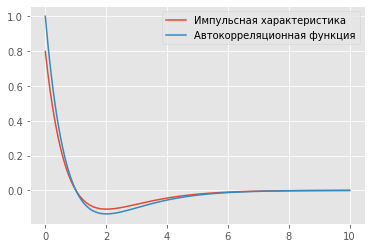

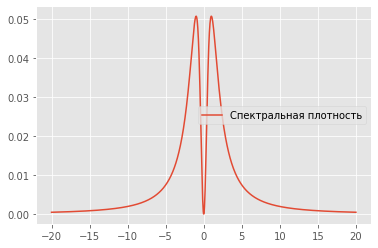

In [1575]:
hs = []
Ss = []
Rs = []

t = np.linspace(t0, t1, n)
oms = np.linspace(-20, 20, 1000)

for k in range(n):
    hs.append(h(dt * k))
    Rs.append(R(dt * k))

for omega in oms:
    Ss.append(S(omega))

plt.plot(t, hs, label='Импульсная характеристика')
plt.plot(t, Rs, label='Автокорреляционная функция')
plt.legend();
plt.show()

plt.plot(oms, Ss, label='Спектральная плотность')
plt.legend();
plt.show()

### Проверка эргодичности процесса (Слуцкий)

In [1576]:
def get_slutsky_criteria(R, T, dt, n):
    return 2 * dt / T * sum((1 - k * dt / T) * R(k * dt) for k in range(n))

def plot_slutsky_criteria(dt, R):
    slutsky = []
    T_vals = list(range(5, 100, 4)) + list(range(100, 200, 7))
    
    for T in T_vals:
        slutsky.append(get_slutsky_criteria(R, T, 0.1, T * 10))
    
    return T_vals, slutsky

In [1577]:
R = get_R(D, α)
T_vals, slutsky = plot_slutsky_criteria(dt, R)

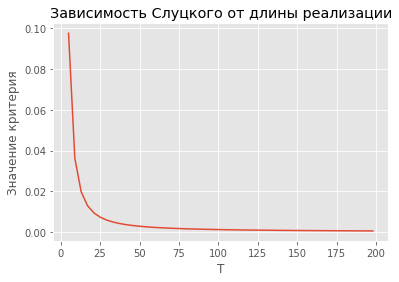

In [1578]:
plt.title('Зависимость Слуцкого от длины реализации')
plt.ylabel('Значение критерия')
plt.xlabel('T')
plt.plot(T_vals, slutsky);

Как видим, процесс эргодический, следовательно можем приступать с исследованию

### Построим реализации процесса

In [1579]:
def get_realization(n, h, dt, hlim=1e-20):
    x = [np.random.uniform(-1, 1) for _ in range(n)]
    y = []
    
    for j in range(n):
        cur_y = 0
        for i in range(j + 1):
            cur_val = h(dt * i) * x[j - i]
            
            if abs(cur_val) < hlim:
                break
            
            cur_y += cur_val
         
        y.append(cur_y)
    
    return y

def get_realizations(t0, t1, n, m, h):
    realizations = []
    t = np.linspace(t0, t1, n)

    for q in range(m):
        y = get_realization(n, h, dt)

        realizations.append(y)
    
    return t, realizations

In [1580]:
t, realizations = get_realizations(t0, t1, n, m, h)

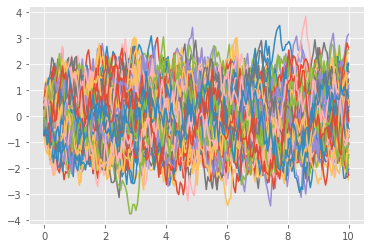

In [1581]:
for y in realizations:
    plt.plot(t, y)

### Усредненные по реализациям матожидания

Для каждого дискретного момента времени посчитаем матожидание по всем реализациям процесса в этот момент времени

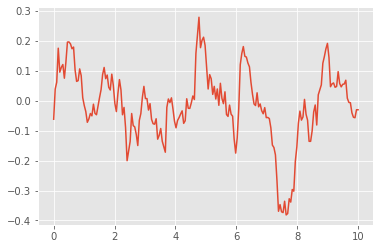

In [1582]:
def get_expectations(realizations, n):
    realizations = np.array(realizations)
    return [np.mean(realizations[:, i]) for i in range(n)]

mys = get_expectations(realizations, n)
plt.plot(t, mys);

### Оценка матожидания для эргодического процесса

In [1583]:
def get_ergodic_exp(y, T, dt):
    return dt / T * sum(y)

def plot_ergodic(dt, h):
    my_erg = []
    T_vals = list(range(5, 100, 2)) + list(range(100, 200, 7)) + list(range(200, 2000, 400))
    
    for T in T_vals:
        big_t, realizations_big_t = get_realizations(0, T, T * 10, 1, h)
        my_erg.append(get_ergodic_exp(realizations_big_t[0], T, 0.1))
    
    return T_vals, my_erg

In [1584]:
T_vals, my_erg = plot_ergodic(dt, h)

In [1585]:
for i in range(len(T_vals)):
    print('Матожидание случайного процесса при T = {:3}: {:.5}'.format(T_vals[i], my_erg[i]))

Матожидание случайного процесса при T =   5: -0.21938
Матожидание случайного процесса при T =   7: -0.33112
Матожидание случайного процесса при T =   9: 0.64853
Матожидание случайного процесса при T =  11: 0.18573
Матожидание случайного процесса при T =  13: 0.41667
Матожидание случайного процесса при T =  15: -0.064264
Матожидание случайного процесса при T =  17: 0.25604
Матожидание случайного процесса при T =  19: -0.0017441
Матожидание случайного процесса при T =  21: -0.11944
Матожидание случайного процесса при T =  23: 0.025308
Матожидание случайного процесса при T =  25: -0.19521
Матожидание случайного процесса при T =  27: -0.19934
Матожидание случайного процесса при T =  29: 0.071449
Матожидание случайного процесса при T =  31: 0.21805
Матожидание случайного процесса при T =  33: 0.19586
Матожидание случайного процесса при T =  35: 0.061316
Матожидание случайного процесса при T =  37: 0.26382
Матожидание случайного процесса при T =  39: 0.023107
Матожидание случайного процесса 

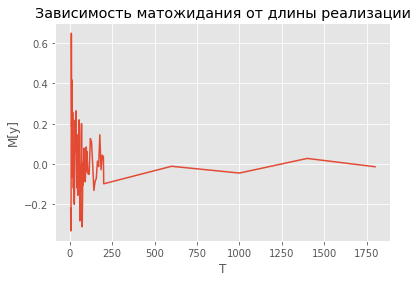

In [1586]:
plt.title('Зависимость матожидания от длины реализации')
plt.ylabel('M[y]')
plt.xlabel('T')
plt.plot(T_vals, my_erg);

### Оценка дисперсии для эргодического процесса

In [1587]:
def get_ergodic_disp(y, T, dt):
    my = get_ergodic_exp(y, T, dt)
    return dt / T * np.sum((np.array(y) - my)**2)

def plot_ergodic_disp(dt, h):
    my_erg = []
    T_vals = list(range(5, 100, 2)) + list(range(100, 200, 7)) + list(range(200, 2000, 400))
    
    for T in T_vals:
        big_t, realizations_big_t = get_realizations(0, T, T * 10, 1, h)
        my_erg.append(get_ergodic_disp(realizations_big_t[0], T, 0.1))
    
    return T_vals, my_erg

In [1588]:
T_vals, my_erg = plot_ergodic_disp(dt, h)

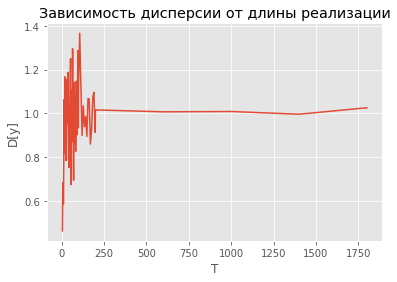

In [1589]:
plt.title('Зависимость дисперсии от длины реализации')
plt.ylabel('D[y]')
plt.xlabel('T')
plt.plot(T_vals, my_erg);

### Доверительные интрвалы для матожиданий

Построим доверительные интервалы для матожиданий в каждый дискретный момент времени

In [1590]:
from statlib.metrics import expectation, dispersion, get_exp_interval
import scipy

def get_expectaion_intervals(realizations, n, prob):
    realizations = np.array(realizations)
    my_l = []
    my_r = []
    mys = []
    
    for i in range(n):
        y_ti = realizations[:, i]
        my = expectation(y_ti)
        σ = math.sqrt(dispersion(y_ti))
        
        my_exp_len = get_exp_interval(σ, prob, len(y_ti))
        
        mys.append(my)
        my_l.append(my - my_exp_len)
        my_r.append(my + my_exp_len)
    
    return mys, my_l, my_r

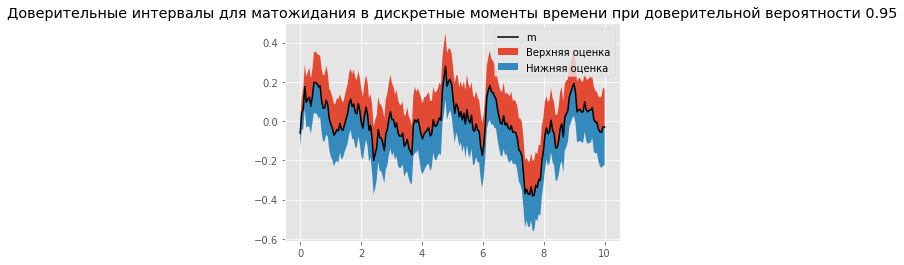

In [1591]:
prob = 0.95
mys, my_l, my_r = get_expectaion_intervals(realizations, n, prob)

plt.title('Доверительные интервалы для матожидания в дискретные моменты времени при доверительной вероятности {}'.format(prob))
plt.fill_between(t, mys, my_r, label='Верхняя оценка')
plt.plot(t, mys, color='black', label='m')
plt.fill_between(t, mys, my_l, label='Нижняя оценка')
plt.legend();

### Доверительный интрвалы для дисперсий

Построим доверительные интервалы для дисперсий в каждый дискретный момент времени

In [1592]:
from statlib.metrics import get_dispersion_borders_known
import scipy

def get_dispersion_intervals(realizations, n, α):
    realizations = np.array(realizations)
    dy_l = []
    dy_r = []
    dys = []
    
    for i in range(n):
        y_ti = realizations[:, i]
        my = expectation(y_ti)
        dy = dispersion(y_ti)
        σ = math.sqrt(dy)
        
        dy_len = get_exp_interval(σ, 1 - α, len(y_ti))
        
        dys.append(dy)
        dy_l.append(dy - dy_len)
        dy_r.append(dy + dy_len)
    
    return dys, dy_l, dy_r

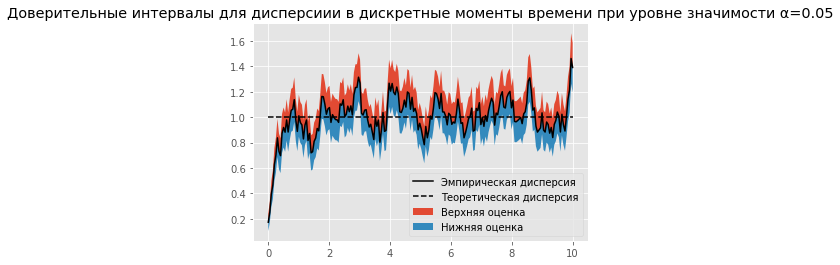

In [1593]:
dy_alpha = 0.05
dys, dy_l, dy_r = get_dispersion_intervals(realizations, n, dy_alpha)

plt.title('Доверительные интервалы для дисперсиии в дискретные моменты времени при уровне значимости α={}'.format(dy_alpha))
plt.hlines(D, t0, t1, linestyles='dashed', label='Теоретическая дисперсия')
plt.fill_between(t, dys, dy_r, label='Верхняя оценка')
plt.plot(t, dys, color='black', label='Эмпирическая дисперсия')
plt.fill_between(t, dys, dy_l, label='Нижняя оценка')
plt.legend();

### Построим эмпирическую автокорреляционную функцию

Найдем эмпирическую автокорреляцию по формуле

$$R_{yy}^M(k\triangle t) = \frac{1}{N-k}\sum_{i=0}^{N-k}y(i\triangle t)y((i + 1)\triangle t)$$

In [1594]:
def emp_R(y, dt, n):
    r_vals = []
    for k in range(n):
        lim = n - k
        r_vals.append((1 / lim) * sum(y[i] * y[i + k] for i in range(lim)))
    
    return r_vals
  
def theor_R(R, dt, n):
    return [R(dt * i) for i in range(n)]

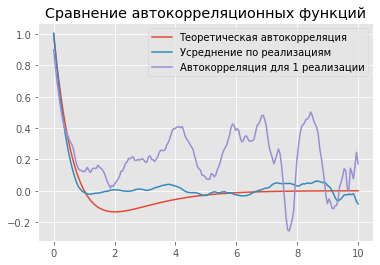

In [1595]:
R = get_R(D, α)

# усреднение по реализациям
rys = np.array([emp_R(realizations[i], dt, n) for i in range(m)])

emp_r = [np.mean(rys[:, i]) for i in range(n)] 
th_R = theor_R(R, dt, n)

plt.title('Сравнение автокорреляционных функций')
plt.plot(t, th_R, label='Теоретическая автокорреляция')
plt.plot(t, emp_r, label='Усреднение по реализациям')
plt.plot(t, rys[0], label='Автокорреляция для 1 реализации')
plt.legend();

### Оценка отклонения эмпирической автокорреляционной функции

In [1596]:
def ek(R_th, R_emp, k):
    return R_emp[k] - R_th[k]

def autocorr_M(R_th, R_emp):
    n = len(R_th)
    return np.mean([ek(R_th, R_emp, k) for k in range(n)])
    
def autocorr_D(R_th, R_emp):
    n = len(R_th)
    mr = autocorr_M(R_th, R_emp)
    return np.mean([(ek(R_th, R_emp, k) - mr)**2 for k in range(n)])

In [1597]:
print('Дисперсия отклонения автокорреляционной функции:', autocorr_D(th_R, emp_r))
print('Матожидание отклонения автокорреляционной функции:', autocorr_M(th_R, emp_r))

Дисперсия отклонения автокорреляционной функции: 0.003394287587915853
Матожидание отклонения автокорреляционной функции: 0.03560523415625634


In [1598]:
def get_arma_realization(n, D, α, σ):
    x = [np.random.uniform(-1, 1) for _ in range(n)]
    y = []
    coeff = math.sqrt(2 * D * α / (math.pi * σ**2))
    
    for k in range(n):
        if k < 2:
            x2 = 0
            y2 = 0
        else:
            x2 = x[k - 2]
            y2 = y[k - 2]
        
        if k < 1:
            y1 = 0
        else:
            y1 = y[k - 1]
        
        y.append(0.04535 * coeff * x[k] - 0.04535 * coeff * x2 + 1.8095 * y1 - 0.8186 * y2)
    
    return y

def get_arma_realizations(t0, t1, n, m, D, α, σ):
    realizations = []
    t = np.linspace(t0, t1, n)

    for q in range(m):
        y = get_arma_realization(n, D, α, σ)
        realizations.append(y)
    
    return t, realizations

In [1603]:
t, arma_realizations = get_arma_realizations(t0, t1, n, m, D, α, 0.07)

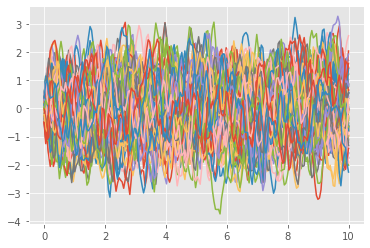

In [1604]:
for y in arma_realizations:
    plt.plot(t, y)

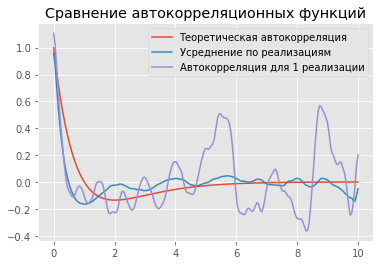

In [1605]:
# усреднение по реализациям
rys_arma = np.array([emp_R(arma_realizations[i], dt, n) for i in range(m)])

emp_r_arma = [np.mean(rys_arma[:, i]) for i in range(n)] 

plt.title('Сравнение автокорреляционных функций')
plt.plot(t, th_R, label='Теоретическая автокорреляция')
plt.plot(t, emp_r_arma, label='Усреднение по реализациям')
plt.plot(t, rys_arma[0], label='Автокорреляция для 1 реализации')
plt.legend();

In [1606]:
print('Дисперсия отклонения автокорреляционной функции:', autocorr_D(th_R, emp_r_arma))
print('Матожидание отклонения автокорреляционной функции:', autocorr_M(th_R, emp_r_arma))

Дисперсия отклонения автокорреляционной функции: 0.009267658856462553
Матожидание отклонения автокорреляционной функции: -0.007445199703426153


In [1318]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

import random


class StationarityTests:
    def __init__(self, significance=0.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.stationary = None

    def ADF_stationarity_test(self, timeseries, printResults=True):
        # Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        self.stationary = self.pValue < self.SignificanceLevel

        if printResults:
            dfResults = pd.Series(adfTest[0:4],
                                  index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])
            # Add Critical Values
            for key, value in adfTest[4].items():
                dfResults['Critical Value (%s)' % key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [1416]:
y = get_realization(n, h, dt)

sTest = StationarityTests()
sTest.ADF_stationarity_test(y, True)
print("Is the time series stationary? {0}".format(sTest.stationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.873928
P-Value                   0.002235
# Lags Used               0.000000
# Observations Used     199.000000
Critical Value (1%)      -3.463645
Critical Value (5%)      -2.876176
Critical Value (10%)     -2.574572
dtype: float64
Is the time series stationary? True
